In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *
from bnbsl import *

from classes import *
from utils import *

In [3]:
SEASON = '21'
set_seed(int(SEASON))

## Download HKJC odds

In [4]:
path_raw = Path('raw_data')
path_data = Path('data')

path_output = Path('output')

In [5]:
session = requests.Session()
r = session.get('http://bet.hkjc.com')
cookies = r.cookies

In [6]:
odds_url = 'https://bet.hkjc.com/football/getJSON.aspx?jsontype=odds_chl.aspx'
response = session.post(
    odds_url,
    headers={'referer':'http://bet.hkjc.com'},
    cookies=cookies
)

In [7]:
with open(path_data/'json'/f'odds_chl-{datetime.now().strftime("%Y-%m-%d-%H-%M-%S")}.txt', 'w') as f:
    f.write(response.text)

In [8]:
matches_json = json.loads(response.text)[1]['matches']

In [9]:
# Example
# matches_json = json.loads(open(path_data/'json'/'odds_chl-2021-11-20-20-15-14.txt').read())[1]['matches']

In [10]:
matches = [Match(m) for m in matches_json if m['matchStatus'] == 'Defined']
odds = [m.export() for m in matches]

['20220415FRI1', '2022-Apr-15', '17:00:00', 'Asian Champions League [ACL]', 'Kawasaki Frontale', 'Ulsan Hyundai', 'true', '9.5', '2.10', '1.65', 'false', '10.5', '2.75', '1.39', 'false', '12.5', '4.90', '1.13']
['20220415FRI2', '2022-Apr-15', '17:45:00', 'Australian Division 1 [AD1]', 'Macarthur FC', 'Brisbane Roar', 'true', '10.5', '1.80', '1.90', 'false', '14.5', '4.30', '1.17', 'false', '11.5', '2.19', '1.60']
['20220415FRI5', '2022-Apr-15', '19:30:00', 'Eng Championship [ED1]', 'Luton', 'Nottingham Forest', 'false', '10.5', '2.30', '1.54', 'true', '9.5', '1.82', '1.88', 'false', '13.5', '4.90', '1.13']
['20220415FRI9', '2022-Apr-15', '22:00:00', 'Eng Championship [ED1]', 'Birmingham', 'Coventry', 'true', '9.5', '1.92', '1.78', 'false', '10.5', '2.45', '1.48', 'false', '12.5', '4.15', '1.18']
['20220415FRI10', '2022-Apr-15', '22:00:00', 'Eng Championship [ED1]', 'Bournemouth', 'Middlesbrough', 'false', '11.5', '2.60', '1.43', 'true', '10.5', '2.02', '1.70', 'false', '13.5', '4.15', 

In [11]:
cols_match = ['MatchDay', 'Date', 'Time', 'LeagueJC', 'HomeTeamJC', 'AwayTeamJC']
cols_odds0 = ['MAINLINE_0', 'CHL_LINE_0', 'CHL_H_0', 'CHL_L_0']
cols_odds1 = ['MAINLINE_1', 'CHL_LINE_1', 'CHL_H_1', 'CHL_L_1']
cols_odds2 = ['MAINLINE_2', 'CHL_LINE_2', 'CHL_H_2', 'CHL_L_2']
cols_odds  = ['MAINLINE', 'CHL_LINE', 'CHL_H', 'CHL_L']
cols_pred  = ['alpha_1', 'alpha_2', 'mu_1', 'mu_2', 'omega', 'corr']

cols = cols_match + cols_odds0 + cols_odds1 + cols_odds2

In [12]:
odds = pd.DataFrame(odds, columns=cols)
odds = odds.fillna(value=np.nan)

In [13]:
cols_odds_ = cols_odds0[1:]+cols_odds1[1:]+cols_odds2[1:]
odds[cols_odds_] = odds[cols_odds_].astype(float)

In [14]:
odds['MatchDay'] = odds['MatchDay'].str[8:]
odds['Date'] = pd.to_datetime(odds['Date'])
odds['Time'] = pd.to_datetime(odds['Time'], format='%H:%M:%S').dt.time

In [15]:
odds['DateTimeJC'] = pd.to_datetime(odds['Date'].dt.date.map(str) + '-' + odds['Time'].map(str))
odds['DateTimeJC'] = odds['DateTimeJC'].dt.tz_localize('Hongkong')
odds['DateTime'] = odds['DateTimeJC'].dt.tz_convert('GB')

In [16]:
map_league = pd.read_csv(path_data/'league.csv')
map_team = pd.read_csv(path_data/'team.csv')

In [17]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2', 'UCL', 'UEC', 'UEF']
map_league = map_league[map_league.Div.isin(div)].reset_index(drop=True)

In [18]:
# Map Div name
odds = odds.merge(map_league[['LeagueJC', 'Div']], 'inner', on='LeagueJC')

In [19]:
# Map Team name
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'HomeTeam'}), 'inner', 
                  left_on='HomeTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])
odds = odds.merge(map_team[['TeamNameJC', 'TeamName']].rename(columns={'TeamName':'AwayTeam'}), 'inner', 
                  left_on='AwayTeamJC', right_on='TeamNameJC').drop(columns=['TeamNameJC'])

## Download recent stats

In [20]:
# Download latest results in current season
!wget -q https://www.football-data.co.uk/mmz4281/{SEASON}{int(SEASON)+1}/data.zip -O raw_data/data.zip

# Unzip to folder
!unzip -q -o raw_data/data.zip -d raw_data/{SEASON}

In [21]:
usecols = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'HC', 'AC', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST']
dtype = {'HC':'float', 'AC':'float'}
parse_dates = ['Date']

seasons = [SEASON]

dfs = []

for folder in sorted(path_raw.iterdir()):
    if folder.is_dir() and folder.name in seasons: 
        for file in sorted(folder.glob('*.csv')):
            try:
                df = pd.read_csv(file, usecols=usecols, dtype=dtype, parse_dates=parse_dates, dayfirst=True)
                df['Season'] = folder.name
                dfs.append(df)
            except:
                continue

In [22]:
df_season = pd.concat(dfs)
df_season = df_season.dropna()
df_season = df_season.sort_values(['Div', 'Date', 'HomeTeam']).reset_index(drop=True)

In [23]:
df_hist = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])
df_hist = df_hist.query(f'Season == {int(SEASON)-1}').reset_index(drop=True)

In [24]:
df_season = pd.concat([df_hist[df_season.columns], df_season])

In [25]:
# Make features on historical stats (Home and Away)
stats = ['FTHG', 'HS', 'HST', 'HC', 'FTAG', 'AS', 'AST', 'AC']
df_home, df_away = joinLastGamesStatsHomeAway(df_season, stats)

In [26]:
# Make features on historical stats (For and Against)
stats = [('FTHG', 'FTAG', 'FTG'), ('HS', 'AS', 'S'), ('HST', 'AST', 'ST'), ('HC', 'AC', 'C')]
df_for, df_against = joinLastGamesStatsForAgainst(df_season, stats)

In [27]:
df_home = df_home.sort_values(['HomeTeam', 'Date']).reset_index(drop=True)
df_away = df_away.sort_values(['AwayTeam', 'Date']).reset_index(drop=True)

df_home = df_home.groupby('HomeTeam')[df_home.columns[df_home.columns.str.contains('Avg')]].last().reset_index()
df_away = df_away.groupby('AwayTeam')[df_away.columns[df_away.columns.str.contains('Avg')]].last().reset_index()

In [28]:
odds = odds.merge(df_home, 'left', 'HomeTeam').merge(df_away, 'left', 'AwayTeam')

In [29]:
cols_home = df_for.columns[df_for.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_for.columns[df_for.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_for = df_for.groupby('Team')[df_for.columns[df_for.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_for.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_for.rename(columns=cols_away), 'left', 'AwayTeam')

In [30]:
cols_home = df_against.columns[df_against.columns.str.contains('Avg')]
cols_home = dict(zip(cols_home, 'Home'+cols_home))
cols_home.update({'Team':'HomeTeam'})

cols_away = df_against.columns[df_against.columns.str.contains('Avg')]
cols_away = dict(zip(cols_home, 'Away'+cols_away))
cols_away.update({'Team':'AwayTeam'})

df_against = df_against.groupby('Team')[df_against.columns[df_against.columns.str.contains('Avg')]].last().reset_index()
odds = odds.merge(df_against.rename(columns=cols_home), 'left', 'HomeTeam').merge(df_against.rename(columns=cols_away), 'left', 'AwayTeam')

In [31]:
add_datepart(odds, 'DateTime', prefix='', drop=False);

In [32]:
display_df(odds.head(5).T)

,0,1,2,3,4
MatchDay,FRI5,FRI9,FRI10,FRI32,FRI35
Date,2022-04-15 00:00:00,2022-04-15 00:00:00,2022-04-15 00:00:00,2022-04-16 00:00:00,2022-04-16 00:00:00
Time,19:30:00,22:00:00,22:00:00,00:30:00,01:00:00
LeagueJC,Eng Championship [ED1],Eng Championship [ED1],Eng Championship [ED1],Eng Championship [ED1],Italian Division 1 [ISA]
HomeTeamJC,Luton,Birmingham,Bournemouth,Huddersfield,Spezia
AwayTeamJC,Nottingham Forest,Coventry,Middlesbrough,QPR,Inter Milan
MAINLINE_0,false,true,false,true,false
CHL_LINE_0,10.5,9.5,11.5,9.5,13.5
CHL_H_0,2.3,1.92,2.6,1.9,4.9
CHL_L_0,1.54,1.78,1.43,1.8,1.13


## Load model

In [33]:
learn_bnb = load_learner('models/learn_bnbsl.pkl')

In [34]:
to = load_pandas('models/to.pkl')

In [35]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [36]:
to_tst = to.new(odds)
to_tst.process()
# to_tst.items.head()

In [37]:
tst_dl = learn_bnb.dls.valid.new(to_tst)
tst_dl.show(max_n=999)

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
0,E1,Luton,Nott'm Forest,9.4,5.6,12.8,5.6,10.8,14.8,11.8,10.4
1,E1,Birmingham,Coventry,9.6,3.4,12.2,4.4,10.6,16.2,9.2,13.6
2,E1,Bournemouth,Middlesbrough,14.2,5.2,12.2,8.2,16.0,10.0,8.2,9.2
3,E1,Huddersfield,QPR,13.0,6.2,7.0,3.4,14.8,7.8,12.4,12.6
4,I1,Spezia,Inter,9.2,4.2,15.6,6.8,9.2,15.4,16.2,14.2
5,I1,Milan,Genoa,15.6,5.6,8.4,3.2,18.0,10.4,9.2,11.2
6,I1,Cagliari,Sassuolo,13.4,5.4,16.2,5.2,11.4,17.6,17.0,13.0
7,I1,Udinese,Empoli,12.2,5.8,11.0,4.4,15.0,7.2,10.6,16.6
8,I1,Sampdoria,Salernitana,10.0,3.6,9.0,3.2,9.2,13.4,12.6,14.2
9,I1,Fiorentina,Venezia,11.8,4.6,7.2,3.2,15.6,11.6,8.0,12.8


In [38]:
pred, _ = learn_bnb.get_preds(dl=tst_dl)

In [39]:
alpha = F.softplus(pred[:, 0:2])
mu = F.softplus(pred[:, 2:4])
omega = pred[:, 4]

total_count = 1. / alpha
logits = torch.log(alpha * mu)

# print(alpha, mu, omega)

In [40]:
# Method 1:
corr = omega * torch.sqrt(mu.prod(-1)) * alpha.prod(-1) / ((1.+alpha)**(1./alpha+1.)).prod(-1) / torch.sqrt((1.+alpha*mu).prod(-1))

In [41]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod(-1)*(1.+alpha*mu).prod(-1)) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod(-1)

In [42]:
odds[cols_pred] = torch.cat([alpha, mu, omega.unsqueeze(-1), corr.unsqueeze(-1)], dim=-1)

In [43]:
odds0 = odds[cols_match+cols_odds0+cols_pred].rename(columns=dict(zip(cols_odds0, cols_odds)))
odds1 = odds[cols_match+cols_odds1+cols_pred].rename(columns=dict(zip(cols_odds1, cols_odds)))
odds2 = odds[cols_match+cols_odds2+cols_pred].rename(columns=dict(zip(cols_odds2, cols_odds)))

In [44]:
odds = pd.concat([odds0, odds1, odds2]).dropna().reset_index(drop=True)
odds['MAINLINE'] = np.where(odds['MAINLINE']=='true', True, False)

In [45]:
odds.head(5)

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,alpha_1,alpha_2,mu_1,mu_2,omega,corr
0,FRI5,2022-04-15,19:30:00,Eng Championship [ED1],Luton,Nottingham Forest,False,10.5,2.30,1.54,0.058792,0.065730,5.908899,5.629369,-35.411522,-0.073964
1,FRI9,2022-04-15,22:00:00,Eng Championship [ED1],Birmingham,Coventry,True,9.5,1.92,1.78,0.084293,0.094445,4.779002,4.523438,-27.947123,-0.090713
2,FRI10,2022-04-15,22:00:00,Eng Championship [ED1],Bournemouth,Middlesbrough,False,11.5,2.60,1.43,0.091290,0.085489,4.689703,5.088659,-29.615364,-0.097953
3,FRI32,2022-04-16,00:30:00,Eng Championship [ED1],Huddersfield,QPR,True,9.5,1.90,1.80,0.072576,0.098923,5.323483,3.933691,-28.770609,-0.084809
4,FRI35,2022-04-16,01:00:00,Italian Division 1 [ISA],Spezia,Inter Milan,False,13.5,4.90,1.13,0.169065,0.049794,2.883415,7.112146,-33.561481,-0.109885


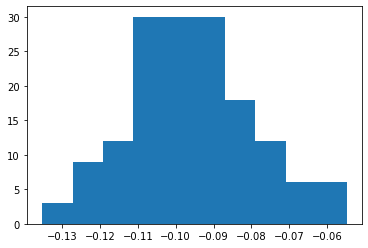

In [46]:
odds['corr'].hist(grid=False);

In [47]:
prob_hilo = []

for r in list(zip(odds['alpha_1'], odds['alpha_2'], odds['mu_1'], odds['mu_2'], odds['omega'], odds['CHL_LINE'])):
    total_count = 1. / torch.tensor(r[0:2], device='cpu') 
    logits = torch.log(torch.tensor(r[0:2], device='cpu') * torch.tensor(r[2:4], device='cpu'))
    omega = torch.tensor(r[4], device='cpu')

    bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)
    value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))
    corner = bnb_corner.log_prob(value).exp()
    
    line = r[5]
    mask = value.sum(-1) < line
    prob_lo = corner[mask].sum()
    prob_hi = 1 - prob_lo
    
    prob_hilo.append([prob_hi.item(), prob_lo.item()])

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [48]:
odds[['prob_hi', 'prob_lo']] = prob_hilo

In [49]:
odds['kelly_hi'] = (odds['prob_hi'] * odds['CHL_H'] - 1) / (odds['CHL_H'] - 1)
odds['kelly_lo'] = (odds['prob_lo'] * odds['CHL_L'] - 1) / (odds['CHL_L'] - 1)

In [50]:
odds['kelly'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], odds['kelly_hi'], odds['kelly_lo']), 
    np.nan
)

In [51]:
odds['bet'] = np.where(
    np.maximum(odds['kelly_hi'], odds['kelly_lo']) > 0, 
    np.where(odds['kelly_hi'] > odds['kelly_lo'], 'High', 'Low'), 
    None
)

In [52]:
odds = odds.sort_values('kelly', ascending=False).reset_index(drop=True)

In [53]:
odds['selected'] = np.where(
    odds['MAINLINE']==True, np.where(
        odds['kelly']>0.3, '$$$', np.where(
            odds['kelly']>0.2, '$$', np.where(
                odds['kelly']>0.1, '$', None))), 
    None
)

In [54]:
odds = odds.drop(columns=cols_pred+['kelly_hi', 'kelly_lo'])

In [55]:
odds[odds.bet.notna() & odds.selected.notna()]

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,FRI5,2022-04-15,19:30:00,Eng Championship [ED1],Luton,Nottingham Forest,True,9.5,1.82,1.88,0.686418,0.313582,0.304000,High,$$$
4,SAT35,2022-04-16,22:15:00,Spanish Division 1 [SFL],Alaves,Vallecano,True,9.5,1.75,1.95,0.374113,0.625887,0.232083,Low,$$
5,SAT8,2022-04-16,18:30:00,Italian Division 1 [ISA],Cagliari,Sassuolo,True,10.5,2.19,1.60,0.570171,0.429829,0.208971,High,$$
7,SAT45,2022-04-17,00:30:00,Spanish Division 1 [SFL],Valencia,Osasuna,True,8.5,1.78,1.92,0.645293,0.354707,0.190541,High,$
9,SAT46,2022-04-17,00:30:00,Italian Division 1 [ISA],Juventus,Bologna,True,9.5,1.78,1.92,0.640552,0.359448,0.179721,High,$
10,FRI47,2022-04-16,03:00:00,Italian Division 1 [ISA],AC Milan,Genoa,True,9.5,1.80,1.90,0.635206,0.364794,0.179213,High,$
12,MON41,2022-04-19,03:00:00,Spanish Division 1 [SFL],Barcelona,Cadiz,True,9.5,1.73,1.98,0.412783,0.587217,0.166011,Low,$
16,SAT17,2022-04-16,20:00:00,Spanish Division 1 [SFL],CF Elche,Mallorca,True,9.5,1.90,1.80,0.376291,0.623709,0.153345,Low,$
17,SAT32,2022-04-16,22:00:00,Eng Premier [EPL],Watford,Brentford,True,10.5,2.19,1.60,0.318935,0.681065,0.149506,Low,$
24,SAT37,2022-04-16,22:30:00,Italian Division 1 [ISA],Fiorentina,Venezia,True,9.5,1.80,1.90,0.410062,0.589938,0.134313,Low,$


In [56]:
display_df(odds[odds.MatchDay.isin(odds[odds.bet.notna() & odds.selected.notna()].MatchDay) & odds.bet.notna()])

,MatchDay,Date,Time,LeagueJC,HomeTeamJC,AwayTeamJC,MAINLINE,CHL_LINE,CHL_H,CHL_L,prob_hi,prob_lo,kelly,bet,selected
0,FRI5,2022-04-15,19:30:00,Eng Championship [ED1],Luton,Nottingham Forest,True,9.5,1.82,1.88,0.686418,0.313582,0.304000,High,$$$
1,FRI5,2022-04-15,19:30:00,Eng Championship [ED1],Luton,Nottingham Forest,False,10.5,2.30,1.54,0.582626,0.417374,0.261570,High,None
2,SAT35,2022-04-16,22:15:00,Spanish Division 1 [SFL],Alaves,Vallecano,False,10.5,2.20,1.59,0.274662,0.725338,0.259809,Low,None
3,MON41,2022-04-19,03:00:00,Spanish Division 1 [SFL],Barcelona,Cadiz,False,13.5,4.55,1.15,0.100146,0.899854,0.232211,Low,None
4,SAT35,2022-04-16,22:15:00,Spanish Division 1 [SFL],Alaves,Vallecano,True,9.5,1.75,1.95,0.374113,0.625887,0.232083,Low,$$
5,SAT8,2022-04-16,18:30:00,Italian Division 1 [ISA],Cagliari,Sassuolo,True,10.5,2.19,1.60,0.570171,0.429829,0.208971,High,$$
6,SAT37,2022-04-16,22:30:00,Italian Division 1 [ISA],Fiorentina,Venezia,False,13.5,4.75,1.14,0.098402,0.901598,0.198724,Low,None
7,SAT45,2022-04-17,00:30:00,Spanish Division 1 [SFL],Valencia,Osasuna,True,8.5,1.78,1.92,0.645293,0.354707,0.190541,High,$
8,MON41,2022-04-19,03:00:00,Spanish Division 1 [SFL],Barcelona,Cadiz,False,10.5,2.17,1.61,0.308266,0.691734,0.186380,Low,None
9,SAT46,2022-04-17,00:30:00,Italian Division 1 [ISA],Juventus,Bologna,True,9.5,1.78,1.92,0.640552,0.359448,0.179721,High,$


In [57]:
odds.to_csv(path_output/f'odds-{datetime.now().strftime("%Y-%m-%d")}.csv', float_format='%.2f', index=False)